#Introduction

Background:
Power of big cloud computing services provided by IaaS companies like microsoft and google have opened doors to a lot of possibilities. Big data analysis has now become more efficient and affordable. Multiple claims were made by the documentary "Ross Kemp and the armed police", the major reason for this project to happen is to prove or disprove the mentioned claim.
The given crime data consists of millions of rows of data, according to Tsai et al., best way to analyse big data is to analyse the data using innovative methods [1]. Also, as seen in [2] Apache spark comes with great deal of features that are best suited to analyse big magnitude of data efficiently.


Objective / Aim:
There are 3 major claims made by the documentary "Ross Kemp and the armed police" with respect to violent crime in UK.
1.	Violent Crime is increasing.
2.	There are more firearms incidents per head in Liverpool than anywhere else in the UK.
3.	Crimes involving firearms are closely associated with drugs offences

The aim of this project is to analyze the data available and to find out whether the claims given above are true or not. For efficient analysis Apache Spark and IaaS (Infrastructure as a service) are preferred.

Technical Approach:

The general approach followed to analyse the data is as follows:

Schema optimization

Filtering required data

Data Preprocessing

Visual Representation

Getting Insights

The approach starts with optimizing the schema of the loaded data, next according to the claim the required data is filtered. After which data preprocessing steps have been undertaken like removing duplicate rows, filling missing values etc. Then comes the visual representation here according to the claim the data is visually analyzed with the help of a graph. Finally insights are obtained based on the analysis.

Additionally, for claim 1 (violent crime is increasing), ARIMA model is used to find the right solution. Stationary test is also used before getting into the model.


#COMPONENT SELECTION & DATA PIPELINE

*   Necessary libraries are imported.
*   Spark session is started and the data is loaded through blob storage container links.
*   Visual inspection of data by finding out unique values and schema is optimized by renaming column names and changing datatype.









In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, year, month, trim, substring, lower, count, sum as _sum
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np


In [ ]:
spark = SparkSession.builder.appName("crime").getOrCreate()
all_crime = r'https://crimkumar.blob.core.windows.net/crimbig/all_crimes21_hdr.txt.gz'
spark.sparkContext.addFile(all_crime)
crime_df = spark.read.option("header", "true").option("delimiter", ",").csv(SparkFiles.get("all_crimes21_hdr.txt.gz"))

In [ ]:
lsoa = r'https://crimkumar.blob.core.windows.net/crimbig/LSOA_data.csv'
spark.sparkContext.addFile(lsoa)
lsoa_df = spark.read.option("header", True).option("delimiter", ",").csv(SparkFiles.get("LSOA_data.csv"))

In [ ]:
num_columns = len(crime_df.columns)
num_rows = crime_df.count()
print(f"The DataFrame has {num_columns} columns and {num_rows} rows.")

The DataFrame has 12 columns and 65078250 rows.


In [ ]:
lsoa_num_columns = len(lsoa_df.columns)
lsoa_num_rows = lsoa_df.count()
print(f"The lsoa_df has {lsoa_num_columns} columns and {lsoa_num_rows} rows.")

The lsoa_df has 12 columns and 34753 rows.


In [ ]:
crime_df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [ ]:
crime_df.show(5)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-0.805600|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|

In [ ]:
target_columns = ["Month", "LSOA name", "Crime type", "Last outcome category", "Context"]

unique_values = {col_name: crime_df.select(col_name).distinct().rdd.map(lambda row: row[0]).collect()
                 for col_name in target_columns}

for column, values in unique_values.items():
    print(f"Column: {column}")
    print(f"Unique Values: {values}\n")

Column: Month
Unique Values: ['2020-06', '2013-05', '2019-10', '2020-12', '2018-10', '2013-09', '2020-02', '2017-09', '2013-12', '2019-11', '2021-04', '2013-06', '2017-10', '2016-02', '2011-05', '2017-05', '2018-06', '2019-03', '2015-05', '2017-11', '2018-03', '2012-08', '2020-05', '2015-12', '2012-02', '2012-04', '2017-03', '2018-02', '2016-12', '2012-05', '2016-09', '2017-08', '2021-03', '2021-02', '2016-03', '2019-07', '2017-06', '2016-10', '2012-12', '2012-07', '2011-03', '2014-01', '2017-02', '2017-04', '2020-11', '2018-05', '2015-02', '2015-08', '2014-03', '2018-08', '2014-08', '2017-07', '2011-01', '2013-11', '2014-02', '2012-01', '2021-05', '2015-10', '2019-05', '2020-07', '2019-08', '2011-11', '2012-11', '2013-02', '2015-11', '2014-09', '2016-05', '2019-01', '2019-09', '2012-06', '2013-07', '2014-05', '2012-09', '2015-01', '2016-04', '2020-03', '2011-08', '2017-12', '2018-11', '2011-04', '2016-11', '2011-09', '2013-08', '2011-07', '2011-10', '2020-01', '2019-06', '2014-11', '2

In [ ]:
crime_df = crime_df.select(
    col("Crime ID").alias("crime_id"),
    col("Month").alias("month").cast("date"),
    col("Reported by").alias("reported_by"),
    col("Falls within").alias("falls_within"),
    col("Longitude").alias("longitude").cast("double"),
    col("Latitude").alias("latitude").cast("double"),
    col("Location").alias("location"),
    col("LSOA code").alias("lsoa_code"),
    col("LSOA name").alias("lsoa_name"),
    col("Crime type").alias("crime_type"),
    col("Last outcome category").alias("last_outcome_category"),
    col("Context").alias("context")
)

In [ ]:
crime_df.printSchema()

root
 |-- crime_id: string (nullable = true)
 |-- month: date (nullable = true)
 |-- reported_by: string (nullable = true)
 |-- falls_within: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- location: string (nullable = true)
 |-- lsoa_code: string (nullable = true)
 |-- lsoa_name: string (nullable = true)
 |-- crime_type: string (nullable = true)
 |-- last_outcome_category: string (nullable = true)
 |-- context: string (nullable = true)



In [ ]:
unique_crime_types = crime_df.select("crime_type").distinct().rdd.flatMap(lambda x: x).collect()
unique_outcome_categories = crime_df.select("last_outcome_category").distinct().rdd.flatMap(lambda x: x).collect()

print("Unique Crime Types:")
for crime_type in unique_crime_types:
    print(crime_type)

print("\nUnique Last Outcome Categories:")
for outcome_category in unique_outcome_categories:
    print(outcome_category)

Unique Crime Types:
Bicycle theft
Public order
Drugs
Public disorder and weapons
Other crime
Robbery
Criminal damage and arson
Theft from the person
Shoplifting
Burglary
Violent crime
Other theft
Possession of weapons
Violence and sexual offences
Vehicle crime
Anti-social behaviour

Unique Last Outcome Categories:
Offender ordered to pay compensation
Offender given suspended prison sentence
Court result unavailable
Defendant sent to Crown Court
Offender given penalty notice
Suspect charged as part of another case
None
Local resolution
Offender given a caution
Offender given conditional discharge
Investigation complete; no suspect identified
Offender given absolute discharge
Under investigation
Awaiting court outcome
Defendant found not guilty
Offender sent to prison
Further investigation is not in the public interest
Further action is not in the public interest
Action to be taken by another organisation
Offender given community sentence
Offender given a drugs possession warning
Formal 

# DATA EXTRACTION & FILTERING                                                                  

*   Required data is filtered from the existing data.
*   Data preprocessing is done by removing duplicate  rows and by extracting useful features from the data.
*   For claim 1 the data is represented with respect to timee.
*   For claim 2 analysis the data is represented by fire arm incident and population
                           




In [ ]:
violent_crime_df = crime_df.filter(
    (col("crime_type") == "Violent crime") | (col("crime_type") == "Violence and sexual offences")
)

In [ ]:
violent_crime_df.printSchema()

root
 |-- crime_id: string (nullable = true)
 |-- month: date (nullable = true)
 |-- reported_by: string (nullable = true)
 |-- falls_within: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- location: string (nullable = true)
 |-- lsoa_code: string (nullable = true)
 |-- lsoa_name: string (nullable = true)
 |-- crime_type: string (nullable = true)
 |-- last_outcome_category: string (nullable = true)
 |-- context: string (nullable = true)



In [ ]:
vc_num_columns = len(violent_crime_df.columns)

vc_num_rows = violent_crime_df.count()

print(f"The DataFrame has {vc_num_columns} columns and {vc_num_rows} rows.")

The DataFrame has 12 columns and 13084759 rows.


In [ ]:
vc_duplicates = (
    violent_crime_df.groupBy(violent_crime_df.columns)
    .count()
    .filter(col("count") > 1)
    .count()
)

print(f"Number of duplicate rows: {vc_duplicates}")

Number of duplicate rows: 176008


In [ ]:
violent_crime_df_cleaned = violent_crime_df.dropDuplicates()


In [ ]:
vc_duplicates_after_removal = (
    violent_crime_df_cleaned.groupBy(*violent_crime_df_cleaned.columns)
    .count()
    .filter(col("count") > 1)
    .count()
)

print(f"Number of duplicate rows after removal: {vc_duplicates_after_removal}")

Number of duplicate rows after removal: 0


In [ ]:
violent_crime_df_cleaned = violent_crime_df_cleaned.withColumn("year", year("month")).withColumn("month_num", month("month"))

In [ ]:
violent_crime_df_cleaned.show(5)

+--------------------+----------+--------------------+--------------------+---------+--------+-----------+---------+---------+--------------------+---------------------+-------+
|            crime_id|     month|         reported_by|        falls_within|longitude|latitude|   location|lsoa_code|lsoa_name|          crime_type|last_outcome_category|context|
+--------------------+----------+--------------------+--------------------+---------+--------+-----------+---------+---------+--------------------+---------------------+-------+
|6c07802f58095c132...|2017-11-01|Avon and Somerset...|Avon and Somerset...|     null|    null|No Location|     null|     null|Violence and sexu...| Awaiting court ou...|   null|
|1444e3ab4acb2aa64...|2016-12-01|Avon and Somerset...|Avon and Somerset...|     null|    null|No Location|     null|     null|Violence and sexu...| Court result unav...|   null|
|35def7b873f14d4d8...|2018-12-01|Avon and Somerset...|Avon and Somerset...|     null|    null|No Location|    

In [ ]:
violent_crime_df_cleaned = violent_crime_df_cleaned.withColumn("year", year("month")).withColumn("month_num", month("month"))

In [ ]:
violent_crime_df_cleaned = violent_crime_df_cleaned.fillna({"last_outcome_category": "Unknown", "context": "Unknown"})

In [ ]:
fa_df = crime_df.filter(
    (
        (lower(col("crime_type")) == "possession of weapons") |
        (lower(col("crime_type")) == "public disorder and weapons")
    ) &
    (lower(col("last_outcome_category")) == "offender sent to prison")
)

In [ ]:
total_fa_incidents = fa_df.count()
total_fa_incidents

18692

In [ ]:
lsoa_df = lsoa_df.withColumnRenamed("geography code", "lsoa_code")
fa_lsoa_df = fa_df.join(lsoa_df, "lsoa_code", "left_outer")

In [ ]:
fa_incident_per_city = fa_lsoa_df.groupBy("geography").agg(
    count("*").alias("total_firearms_incidents")
)

In [ ]:
fa_incident_per_city.show(5)

+---------------+------------------------+
|      geography|total_firearms_incidents|
+---------------+------------------------+
| Sheffield 074C|                      22|
|  Bradford 039G|                      38|
| Blackpool 010D|                      16|
|Calderdale 014C|                       1|
|     Brent 018D|                       1|
+---------------+------------------------+
only showing top 5 rows



In [ ]:
fa_incident_city_population = fa_incident_per_city.join(
    lsoa_df.select(col("geography"), col("Variable: All usual residents; measures: Value").alias("population")),
    "geography",
    "left_outer"
)

In [ ]:
fa_per_head = fa_incident_city_population.withColumn(
    "incidents_per_head",
    col("total_firearms_incidents") / col("population")
)

In [ ]:
fa_per_head.orderBy(col("incidents_per_head").desc()).show(fa_per_head.count(), truncate=False)


+---------------------------------+------------------------+----------+---------------------+
|geography                        |total_firearms_incidents|population|incidents_per_head   |
+---------------------------------+------------------------+----------+---------------------+
|Cardiff 032F                     |46                      |1020      |0.045098039215686274 |
|Kingston upon Hull 029E          |58                      |1314      |0.0441400304414003   |
|Birmingham 138A                  |42                      |1020      |0.041176470588235294 |
|Nottingham 039E                  |36                      |1049      |0.034318398474737846 |
|Bradford 039G                    |38                      |1138      |0.033391915641476276 |
|Nottingham 039B                  |37                      |1309      |0.02826585179526356  |
|Manchester 055B                  |45                      |1670      |0.02694610778443114  |
|Manchester 054C                  |34                      |

In [ ]:
fa_per_head = fa_per_head.withColumn("city", regexp_replace(col("geography"), r"\s\d+[A-Z]$", ""))


In [ ]:
fa_city = fa_per_head.groupBy("city").agg(
    _sum("total_firearms_incidents").alias("total_firearms_incidents"),
    _sum("population").alias("total_population")
)
fa_city = fa_city.withColumn("incidents_per_head", col("total_firearms_incidents") / col("total_population"))

In [ ]:
fa_city.orderBy(col("incidents_per_head").desc()).show(fa_per_head.count(), truncate=False)

+----------------------------+------------------------+----------------+---------------------+
|city                        |total_firearms_incidents|total_population|incidents_per_head   |
+----------------------------+------------------------+----------------+---------------------+
|City of London              |28                      |6029.0          |0.004644219605241333 |
|Worcester                   |98                      |44470.0         |0.0022037328536091746|
|Torbay                      |109                     |49588.0         |0.0021981124465596516|
|Westminster                 |264                     |121371.0        |0.0021751489235484586|
|Darlington                  |76                      |36812.0         |0.0020645441703792244|
|Middlesbrough               |118                     |58437.0         |0.002019268614063008 |
|Kingston upon Hull          |274                     |135858.0        |0.0020168116710094362|
|North East Lincolnshire     |123                 

In [ ]:
drugs_df = crime_df.filter(col("Crime type") == "Drugs")


In [ ]:
from pyspark.sql import functions as F

fa_drugs_overlap = fa_df.join(
    drugs_df,
    ["lsoa_code", "Month"],
    "inner"
).select(
    fa_df["lsoa_code"],
    fa_df["Month"],
    fa_df["crime_id"].alias("firearms_crime_id"),
    drugs_df["crime_id"].alias("drugs_crime_id")
)

# Count the rows in the resulting DataFrame
row_count = fa_drugs_overlap.count()
print("Number of rows in the joined DataFrame:", row_count)


Number of rows in the joined DataFrame: 44831


In [ ]:
violent_yearly_trend = violent_crime_df_cleaned.groupBy(year("month").alias("year")) \
                             .agg(count("*").alias("crime_count")) \
                             .orderBy("year")
violent_yearly_trend.show()

+----+-----------+
|year|crime_count|
+----+-----------+
|2010|      40216|
|2011|     543575|
|2012|     669109|
|2013|     680906|
|2014|     832918|
|2015|    1041780|
|2016|    1230984|
|2017|    1500466|
|2018|    1759381|
|2019|    1865528|
|2020|    1855409|
|2021|     762123|
+----+-----------+



In [ ]:
violent_trend_df = violent_crimes_trend.toPandas()

print(violent_trend_df)

     year  month_num  crime_count
0    2010         12        40216
1    2011          1        41663
2    2011          2        39932
3    2011          3        43613
4    2011          4        46274
..    ...        ...          ...
121  2021          1       140756
122  2021          2       134299
123  2021          3       165358
124  2021          4       152303
125  2021          5       169407

[126 rows x 3 columns]


#VISUALIZATION

Different types of visualizations were chosen for different claims:
Claim 1: Violent Crime Increasing
For this since this is a time analysis the best case of visualization would be line graph.
Here the violent crime is filtered from the data and is mapped in the linegraph with respect to its years. Through this line graph we are able to obtain a clear view of the trend of the violent crimes throughout the years.

Claim 2: There are more firearms incidents per head in Liverpool than anywhere else in the UK

This claim is based on the population of the cities so a distribution bar graph is drawn to analyse the standing of the liverpools firearm incident with respect to the other cities.

In [ ]:
violent_yearly_trend_df = violent_yearly_trend.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(
    violent_yearly_trend_df["year"],
    violent_yearly_trend_df["crime_count"],
    marker='o',
    linestyle='-'
)
plt.title("Yearly Trend of Violent Crimes")
plt.xlabel("Year")
plt.ylabel("Number of Violent Crimes")
plt.xticks(violent_yearly_trend_df["year"], rotation=45)  # Adjust the x-axis labels
plt.grid()
plt.show()

NameError: name 'violent_yearly_trend' is not defined

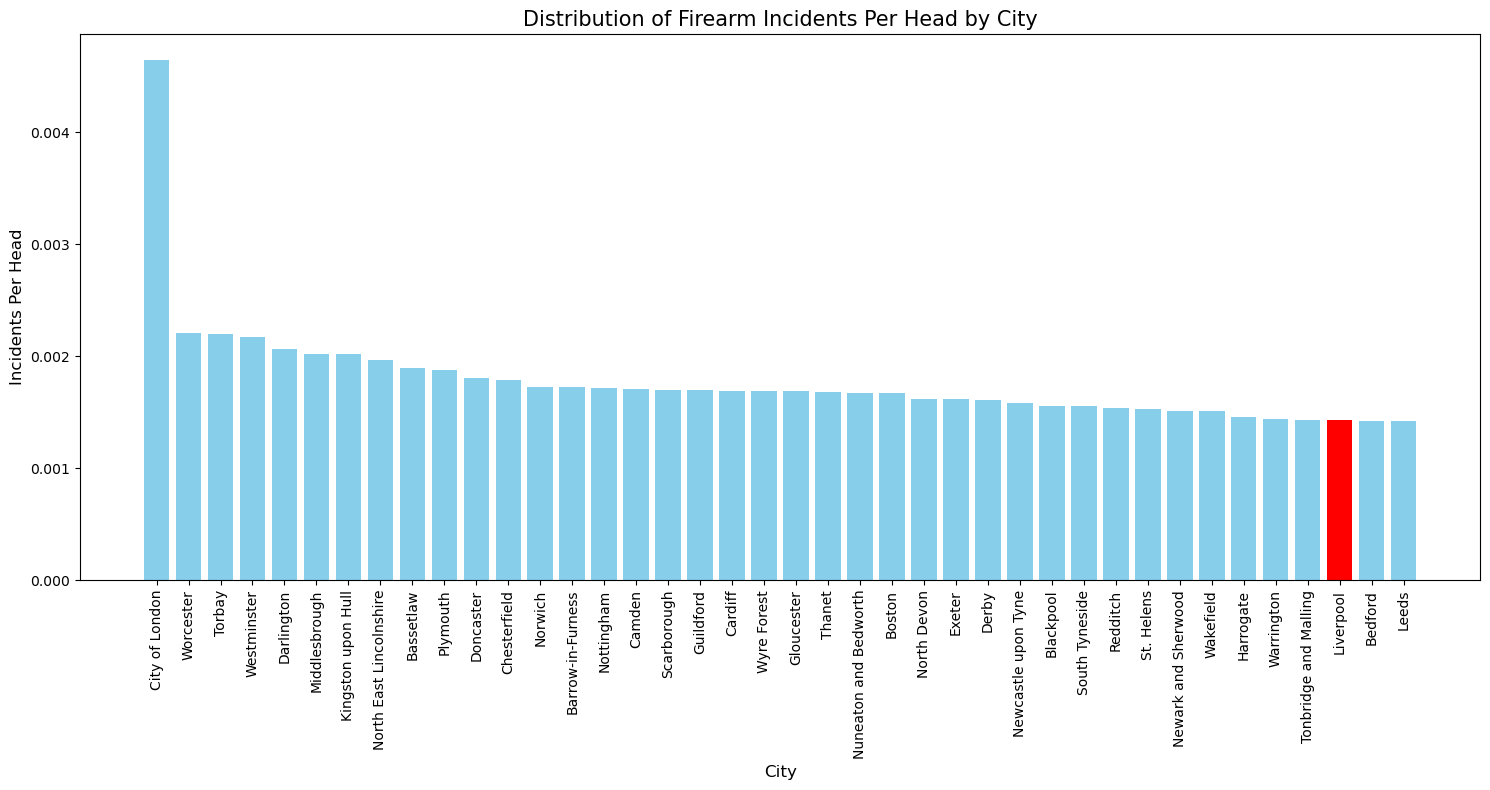

In [ ]:
fa_city_pandas = fa_city.select("city", "incidents_per_head").toPandas()
fa_city_pandas = fa_city_pandas[fa_city_pandas["city"].notnull()]

fa_city_pandas = fa_city_pandas.sort_values(by="incidents_per_head", ascending=False)

fa_city_pandas = fa_city_pandas.head(40)


colors = ['red' if city == 'Liverpool' else 'skyblue' for city in fa_city_pandas["city"]]

plt.figure(figsize=(15, 8))
plt.bar(fa_city_pandas["city"], fa_city_pandas["incidents_per_head"], color=colors)
plt.xlabel("City", fontsize=12)
plt.ylabel("Incidents Per Head", fontsize=12)
plt.title("Distribution of Firearm Incidents Per Head by City", fontsize=15)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
violent_crimes_trend = violent_crime_df_cleaned.groupBy(year("month").alias("year"), month("month").alias("month_num")) \
                                     .agg(count("*").alias("crime_count")) \
                                     .orderBy("year", "month_num")

In [ ]:

# Perform ADF test
adf_test = adfuller(violent_trend_df['crime_count'])

# Extract results
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

# Print results
print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -0.4614756070142527
P-Value: 0.8993175741270057
Critical Values:
  1%: -3.4901313156261384
  5%: -2.8877122815688776
  10%: -2.5807296460459184
The series is non-stationary (fail to reject the null hypothesis).


In [ ]:
# Apply first-order differencing
violent_trend_df['crime_count_diff'] = violent_trend_df['crime_count'].diff()

# Drop the first NaN value introduced by differencing
violent_trend_df = violent_trend_df.dropna()

# Re-run the ADF test
from statsmodels.tsa.stattools import adfuller

adf_test_diff = adfuller(violent_trend_df['crime_count_diff'])
adf_statistic = adf_test_diff[0]
p_value = adf_test_diff[1]
critical_values = adf_test_diff[4]

print(f"ADF Statistic (After Differencing): {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

if p_value < 0.05:
    print("The differenced series is stationary (reject the null hypothesis).")
else:
    print("The differenced series is still non-stationary (fail to reject the null hypothesis).")


ADF Statistic (After Differencing): -2.470600987226712
P-Value: 0.12279224704663955
Critical Values:
  1%: -3.490683082754047
  5%: -2.8879516565798817
  10%: -2.5808574442009578
The differenced series is still non-stationary (fail to reject the null hypothesis).


In [ ]:
# Second-order differencing
violent_trend_df = violent_trend_df.assign(crime_count_diff2=violent_trend_df['crime_count'].diff().diff())

violent_trend_df = violent_trend_df.dropna()

adf_test_diff2 = adfuller(violent_trend_df['crime_count_diff2'])
adf_statistic = adf_test_diff2[0]
p_value = adf_test_diff2[1]
critical_values = adf_test_diff2[4]

print(f"ADF Statistic (Second-Order Differencing): {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

if p_value < 0.05:
    print("The second-order differenced series is stationary (reject the null hypothesis).")
else:
    print("The second-order differenced series is still non-stationary (fail to reject the null hypothesis).")


ADF Statistic (Second-Order Differencing): -6.4496601974042225
P-Value: 1.5346944610543413e-08
Critical Values:
  1%: -3.492995948509562
  5%: -2.888954648057252
  10%: -2.58139291903223
The second-order differenced series is stationary (reject the null hypothesis).


<Figure size 640x480 with 0 Axes>

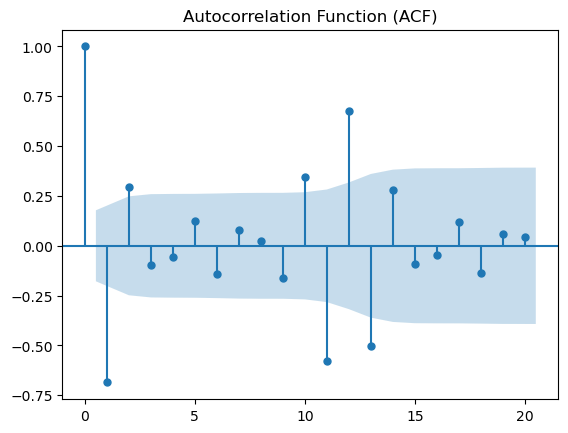

<Figure size 640x480 with 0 Axes>

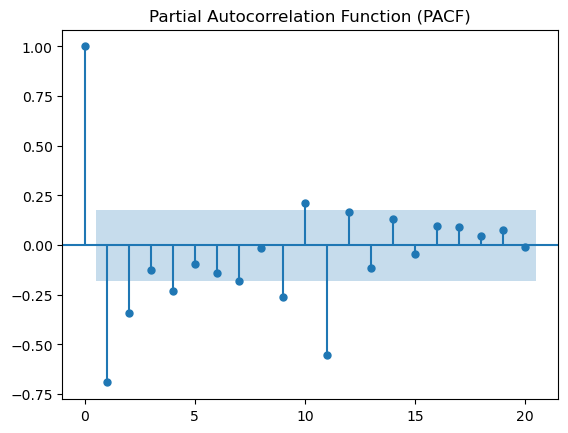

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure()  # Create a new figure
plot_acf(violent_trend_df['crime_count_diff2'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()
plt.close()  # Close the current figure

# PACF plot
plt.figure()  # Create a new figure
plot_pacf(violent_trend_df['crime_count_diff2'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()
plt.close()  # Close the current figure

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(violent_trend_df['crime_count_diff2'], order=(1, 0, 1))
arima_result = arima_model.fit()

print(arima_result.summary())


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                               SARIMAX Results                                
Dep. Variable:      crime_count_diff2   No. Observations:                  121
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1250.786
Date:                Thu, 23 Jan 2025   AIC                           2509.572
Time:                        01:36:37   BIC                           2520.755
Sample:                             0   HQIC                          2514.114
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4183     11.353      0.125      0.901     -20.834      23.671
ar.L1         -0.3479      0.079     -4.391      0.000      -0.503      -0.193
ma.L1         -1.0000      0.100     -9.968      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


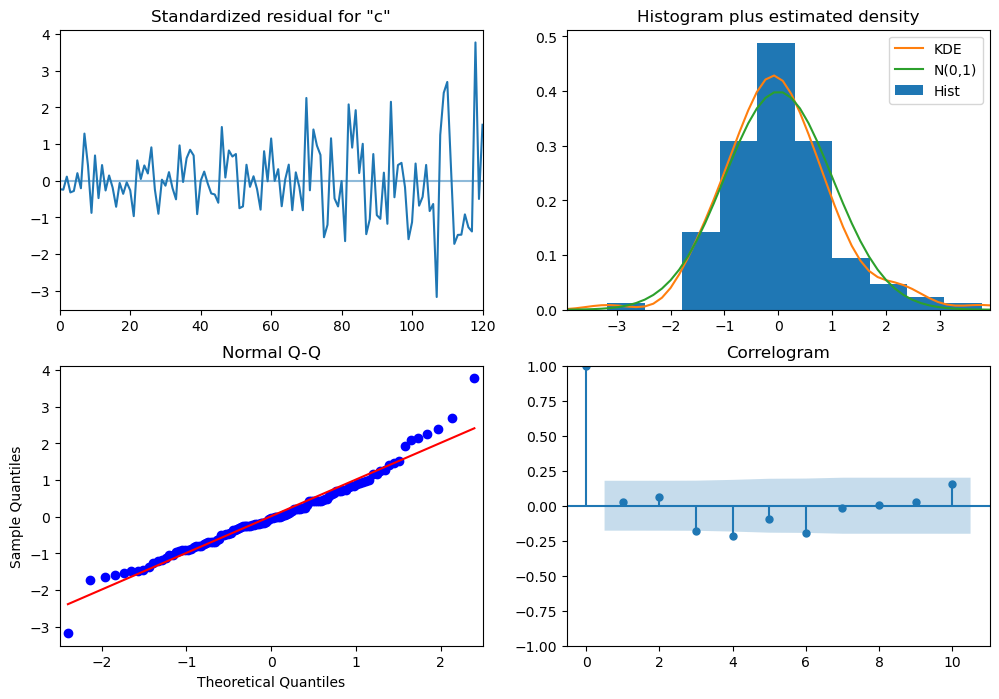

In [ ]:
# Plot the diagnostics
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

In [ ]:
fa_drugs_overlap = fa_drugs_overlap.groupBy("lsoa_code", "Month").agg(
    F.countDistinct(col("firearms_crime_id")).alias("firearms_count"),
    F.countDistinct(col("drugs_crime_id")).alias("drugs_count")
)

# Calculating correlation between 'firearms_count' and 'drugs_count'
correlation = fa_drugs_overlap.stat.corr("firearms_count", "drugs_count")
print("Correlation coefficient between firearms_count and drugs_count:", correlation)

Correlation coefficient between firearms_count and drugs_count: 1.0


REFERENCES:

[1] C.W. Tsai, C.F. Lai, H.C. Chao, and A.V. Vasilakos, "Big data analytics: a survey," Journal of Big Data, vol. 2, pp. 1-32, 2015.

[2] A. Gupta, H. K. Thakur, R. Shrivastava, P. Kumar, and S. Nag, "A Big Data Analysis Framework Using Apache Spark and Deep Learning," 2017 IEEE International Conference on Data Mining Workshops (ICDMW), New Orleans, LA, USA, 2017, pp. 9–16, doi: 10.1109/ICDMW.2017.9.

